In [3]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Flatten, Input
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import pickle
from PIL import Image

In [4]:
labels = pd.read_csv('/content/drive/MyDrive/data/labels.csv')
labels

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [5]:
dir = "/content/drive/MyDrive/data"

In [6]:
 d= dict()
class_labels = dict()
for dirs in os.listdir(dir + '/mydata'):
    count = len(os.listdir(dir +'/mydata/'+dirs))
    d[dirs+' : '+labels[labels.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = labels[labels.ClassId == int(dirs)].values[0][1]
len(d)

43

In [7]:
labelnum0=[]
dirs= "/content/drive/MyDrive/data/mydata"
for file in os.listdir(dirs):
    labelnum0+=[int(file)]
labelnum=sorted(labelnum0)

In [22]:
images=[]
classno=[]
count=0
for x in range (0,len(d)):
    myPicList = os.listdir(dirs+"/"+str(count))#[:limiting]
    for y in myPicList:
        curImg = cv2.imread(dirs+"/"+str(count)+"/"+y)
        images.append(curImg)
        classno.append(count)
    print(count, end =" ")
    count +=1

images = np.array(images)
classno = np.array(classno)

train_x, test_x, train_y, test_y = train_test_split(images, classno, test_size=0.2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  


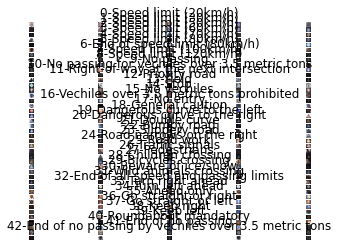

In [23]:
import random
num_of_samples = []
num_classes = len(d)
cols=5
fig, axs = plt.subplots(nrows=num_classes, ncols=cols)#, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in labels.iterrows():
        x_selected = train_x[train_y== j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))

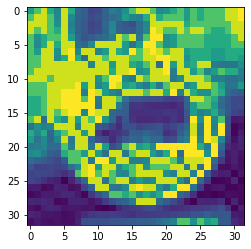

In [24]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img

train_x=np.array(list(map(preprocessing,train_x)))  # TO IRETATE AND PREPROCESS ALL IMAGES
test_x=np.array(list(map(preprocessing,test_x)))
plt.imshow(train_x[random.randint(0,len(train_x)-1)])
plt.show()

In [25]:
train_x=train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
test_x=test_x.reshape(test_x.shape[0],test_x.shape[1],test_x.shape[2],1)

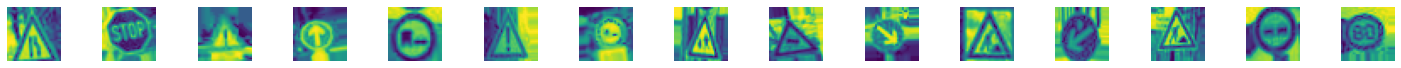

In [30]:
imageDimesions = (32,32,3)
dataGen= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)  # DEGREES
dataGen.fit(train_x)
batches= dataGen.flow(train_x,train_y,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)

# TO SHOW AGMENTED IMAGE SAMPLES
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimesions[0],imageDimesions[1]))
    axs[i].axis('off')
plt.show()


train_y = to_categorical(train_y,len(d))
test_y = to_categorical(test_y,len(d))

In [45]:
batch_size_val=50  # how many to process together
steps_per_epoch_val=200
epochs_val=20
noOfClasses=len(d)
def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                         # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500   # NO. OF NODES IN HIDDEN LAYERS
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])
    return model


model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(train_x,train_y,batch_size=batch_size_val),steps_per_epoch=steps_per_epoch_val,epochs=epochs_val,validation_data=(test_x,test_y),shuffle=1)
train_data=(train_x,train_y)
test_data = (test_x,test_y)
history

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 4, 4, 30)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
200/200 [==============================] - 110s 549ms/step - loss: 3.3068 - accuracy: 0.1365 - val_loss: 1.9361 - val_accuracy: 0.4257
Epoch 2/20
200/200 [==============================] - 109s 544ms/step - loss: 2.0689 - accuracy: 0.4086 - val_loss: 0.8789 - val_accuracy: 0.7697
Epoch 3/20
200/200 [==============================] - 108s 543ms/step - loss: 1.5034 - accuracy: 0.5507 - val_loss: 0.6160 - val_accuracy: 0.8241
Epoch 4/20
200/200 [==============================] - 109s 544ms/step - loss: 1.2153 - accuracy: 0.6309 - val_loss: 0.4307 - val_accuracy: 0.8841
Epoch 5/20
200/200 [==============================] - 108s 542ms/step - loss: 1.0165 - accuracy: 0.6811 - val_loss: 0.3188 - val_accuracy: 0.9139
Epoch 6/20
200/200 [==============================] - 109s 543ms/step - loss: 0.8993 - accuracy: 0.7185 - val_loss: 0.2795 - val_accuracy: 0.9330
Epoch 7/20
200/200 [==============================] - 108s 541ms/step - loss: 0.8032 - accuracy: 0.7517 - val_loss: 0.2061 -

In [47]:
model.save("model.h5")

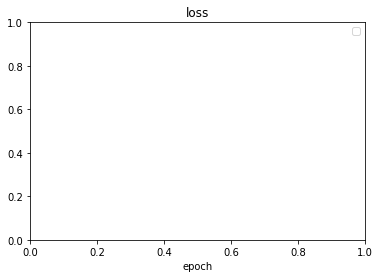

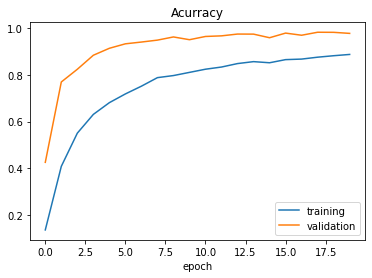

Test Score: 0.07600177079439163
Test Accuracy: 0.9776217341423035


In [62]:
#print(history['loss'], history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(test_x,test_y,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])